In [1]:
import pandas as pd
import numpy as np
import re
from datetime import datetime
from ggplot import *
%matplotlib inline

/Users/erourke/anaconda/lib/python3.5/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/Users/erourke/anaconda/lib/python3.5/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/Users/erourke/anaconda/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
data_path = '/Users/erourke/Desktop'
loans_full = pd.read_csv(data_path+'/loans_full.csv', low_memory=False)
loans_details = pd.read_csv(data_path+'/loans_details.csv', low_memory=False)

In [4]:
additional_columns =  loans_full.columns.difference(loans_details.columns).tolist() + ['id']
df = loans_details.merge(loans_full[['id', 'borrower_count']], left_on='id', right_on='id')

In [5]:
df = df.rename(columns={'terms.disbursal_date': 'disbursal_date'})

## convert columns to datetime format
df['funded_date_cln'] = pd.to_datetime(df.funded_date.str[:10], infer_datetime_format=True)
df['post_date_cln'] = pd.to_datetime(df.posted_date.str[:10], infer_datetime_format=True)
df['disb_date_cln'] = pd.to_datetime(df.disbursal_date.str[:10], infer_datetime_format=True)
df['exp_date_cln'] = pd.to_datetime(df.planned_expiration_date.str[:10], infer_datetime_format=True)

## Time to fund is the funded date minus the posted date
df['time_to_fund'] =df['funded_date_cln'] - df['post_date_cln']
df['days_to_fund'] = df.time_to_fund.dt.days

## Time to dispursement is the Disbursed date minus the Posted Date
df['time_to_disb'] =df['disb_date_cln'] - df['post_date_cln']
df['days_to_disb'] = df.time_to_disb.dt.days

## Time to expiration is the expiration date minus the Posted Date
df['time_to_exp'] =df['exp_date_cln'] - df['post_date_cln']
df['days_to_exp'] = df.time_to_exp.dt.days

In [17]:
## Male/Female 
#  Note the apply function
df['male'] = df['borrowers'].apply(lambda x: x.split("gender': '")[1][0]=='M')

## Whether or not the borrower is widowed
#  Note the str.contains function
df['widowed'] = np.where(df['description.texts.en'].str.contains("widowed|widow", na=False) ==True, True, False)

## Whether or not the borrower has children 
df['kids'] = np.where(df['description.texts.en'].str.contains("kids|child|children|kid|son|daughter", na=False) ==True,True,False)

In [21]:
## Features of the loan posting

## Does the borrower include a video? 
df['video'] = np.where(pd.isnull(df['video.id']) ==False, True, False)

## Does the borrower include a picture? 
df['pictured'] = np.where(pd.isnull(df['image.id']) ==False, True, False)

In [22]:
import statsmodels.formula.api as sm

# Set training-test split %
split_pct = 0.80

# the pandas command "sample" already randomizes its selection. 
loans_full_shuffled = df.sample(frac=1)

train_set = loans_full_shuffled[:int((len(loans_full_shuffled)+1*split_pct))] 
test_set = loans_full_shuffled[int(len(loans_full_shuffled)*split_pct+1):]  

# Now we have two separate datasets: train_set and test_set. We will run the regression on train_set
# using statsmodel's "ols" function. Let's try a simple example to start:

model1 = sm.ols(formula="days_to_fund ~ loan_amount", data=train_set).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:           days_to_fund   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     2448.
Date:                Fri, 26 May 2017   Prob (F-statistic):               0.00
Time:                        10:45:10   Log-Likelihood:            -4.8066e+05
No. Observations:              122331   AIC:                         9.613e+05
Df Residuals:                  122329   BIC:                         9.613e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       6.9034      0.043    161.535      

## Validation of Model 1

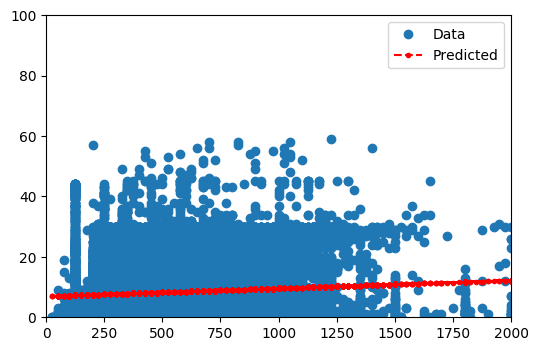

In [12]:
import matplotlib.pyplot as plt
test_set2 = test_set.fillna(method='ffill')
y_pred = model1.predict(test_set2)
y_pred

## Visualize the predicted values v. real
y_pred['predictions'] = model1.predict(test_set2)
fig, ax = plt.subplots()
ax.plot(test_set['loan_amount'], test_set['days_to_fund'], 'o', label="Data")
ax.plot(test_set['loan_amount'], y_pred['predictions'], 'r--.', label="Predicted")
axes = plt.gca()
axes.set_xlim([0,2000])
axes.set_ylim([0,100])
ax.legend(loc="best");

In [13]:
from sklearn import datasets, linear_model
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

y_true = test_set2['days_to_fund']
y_pred = y_pred['predictions']

## Explained variance from the model
explained_variance_score(y_true, y_pred, multioutput='raw_values') 

array([ 0.01363406])

In [14]:
## Explained Mean absolute error
mean_absolute_error(y_true, y_pred)

8.7231576979029821

In [15]:
## Explained Mean square error
mean_squared_error(y_true, y_pred)

158.9231418137075

## Validation of model 2

In [23]:
model2 = sm.ols(formula="days_to_fund ~ days_to_exp + borrower_count + loan_amount + sector + kids + male+ widowed + pictured + video", data=train_set).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:           days_to_fund   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     657.7
Date:                Fri, 26 May 2017   Prob (F-statistic):               0.00
Time:                        10:45:14   Log-Likelihood:            -3.6718e+05
No. Observations:               97418   AIC:                         7.344e+05
Df Residuals:                   97396   BIC:                         7.346e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [24]:
test_set2 = test_set.fillna(method='ffill')
y_pred2 = model2.predict(test_set2)


In [25]:
## Explained variance from the model
explained_variance_score(y_true, y_pred2, multioutput='raw_values') 

array([-0.10698931])

In [26]:
## Explained Mean absolute error of model 2
mean_absolute_error(y_true, y_pred2)

9.7466409529440696

In [27]:
## Explained Mean square error of model 2
mean_squared_error(y_true, y_pred2)

180.7647102751601